# Определение стоимости автомобилей <a id="title"></a>

**Цель исследования**:

1. Проанализировать данные о технических характеристиках, комплектации и ценах автомобилей.
2. Разработать модель, которая будет определять стоимость автомобиля по его характеристикам. Заказчику важно как качество модели, так и скорость обучения и предсказания.


**Ход исследования**:

Основные данные получаем из файла: ```autos.csv```. Он содержит исторические данные из анкет клиентов сервиса по продаже автомобилей с пробегом.

Мы проверим данные на наличие пропусков и дубликатов, приведем данные к нужному формату. 
Затем проведем анализ данных, опишем общую информацию о характеристиках автомобилей в таблице. Проверим данные на наличие аномальных значений. 
После чего подготовим выборку для обучения моделей. Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели подберем гиперпараметры.
Затем проанализируем время обучения, время предсказания и качество моделей.
Наконец, опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

Таким образом, исследование пройдет в 7 этапов
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка выборки, использование пайплайнов для подбора гиперпараметров моделей
5. Анализ качества и скорости моделей с подобранными на предыдущем шаге гиперпараметрами
6. Выбор лучшей модели, получение результатов на тестовой выборке
7. Написание общего вывода

## Подготовка данных

### Импорт библиотек и объявление констант

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [3]:
RANDOM_STATE = 42
RMSE_THRESHOLD = 2500

### Загрузка данных

In [4]:
data = pd.read_csv('./datasets/autos.csv')

Посмотрим на первые строки датафрейма.

In [5]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Выведем общую информацию о датафрейме.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датафрейме 16 столбцов и 354369 строк. 7 столбцов содержат целочисленные значения - ```Price```, ```RegistrationYear```, ```Power```, ```Kilometer```, ```RegistrationMonth```, ```NumberOfPictures```, ```PostalCode```, 9 - строковые: ```DateCrawled```, ```VehicleType```, ```Gearbox```, ```Model```, ```FuelType```, ```Brand```, ```Repaired```, ```DateCreated```,  ```LastSeen```.

Наблюдаются пропуски в столбцах ```VehicleType```, ```Gearbox```, ```Model```, ```FuelType```, ```Repaired```.

### Предобработка данных

#### Проверка наличия пропусков

In [7]:
frame = ({'Количество пропусков' : data.isna().sum().sort_values(ascending=False), 
          'Доля пропусков, %' : round((data.isna().mean()*100), 2).sort_values(ascending=False)})
pd.DataFrame(frame).sort_values(by='Доля пропусков, %', ascending=False)

,Количество пропусков,"Доля пропусков, %"
Repaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56
DateCrawled,0,0.00
Price,0,0.00
RegistrationYear,0,0.00
Power,0,0.00
Kilometer,0,0.00


Пропуски содержатся в 5 столбцах - ```Repaired```, ```VehicleType```, ```FuelType```, ```Gearbox```, ```Model```.

In [8]:
for col in ['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']:
    display(data[col].value_counts(dropna=False))

Repaired
no     247161
NaN     71154
yes     36054
Name: count, dtype: int64

VehicleType
sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

FuelType
petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

Gearbox
manual    268251
auto       66285
NaN        19833
Name: count, dtype: int64

Model
golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 251, dtype: int64

Все столбцы содержат категориальные данные, при этом пропусков достаточно большое количество. Удалять пропуски не будем, заполним их заглушкой ```unknown```.

In [9]:
data = data.fillna('unknown')

In [10]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

#### Проверка типов данных

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Столбцы с датами имеют строковый тип. Переведем их в datetime.

In [12]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')

In [13]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

#### Проверка наличия дубликатов

In [15]:
data.duplicated().sum()

4

В датафрейме всего 4 явных дубликата, удалим их.

In [16]:
data = data.drop_duplicates().reset_index(drop=True)

In [17]:
data.duplicated().sum()

0

#### Предобработка данных - итог

Провели предобработку данных.
1. Пропуски обнаружены в категориальных столбцах ```Repaired```, ```VehicleType```, ```FuelType```, ```Gearbox```, ```Model```. Заполнили пропуски заглушкой "unknown".
2. Привели даты к типу datetime.
3. Удалили явные дубликаты.

### Исследовательский анализ данных

####  Вспомогательные функции

In [18]:
def describe_numeric(df, col, discrete=False):
    """Описывает количественный параметр col датафрейма df.
    Опционально можно задать признак дискретности данных discrete.
    Выводит описательную статистику параметра и строит боксплот.
    Возвращает сетку и оси графика.
    """
    if not discrete:
        print(col + ':')
        print(df[col].describe())
        fig, ax = plt.subplots(figsize=(5,10))
        df.boxplot(col, ax=ax)
    else:
        print(df[col].value_counts().sort_index())
        fig, ax = plt.subplots(figsize=(5,10))
        df.boxplot(col, ax=ax)
    return fig, ax

In [19]:
def describe_categorical(df, col):
    """Описывает категориальный параметр col датафрейма df.
    Выводит value_counts параметра и строит барплот.
    Возвращает сетку и оси графика.
    """
    print(df[col].value_counts())
    fig, ax = plt.subplots()
    df[col].value_counts().plot(kind='bar')
    return fig, ax

#### DateCrawled

```DateCrawled``` — дата скачивания анкеты из базы.

In [20]:
data['DateCrawled'].describe()

count                           354365
mean     2016-03-21 12:58:09.520460544
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

В датафрейме есть данные об объявлениях, скачанных в период с 2016-03-05 по 2016-04-07. Для обучения этот столбец не представляет особой ценности.

#### VehicleType

```VehicleType``` — тип автомобильного кузова.

VehicleType
sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: count, dtype: int64


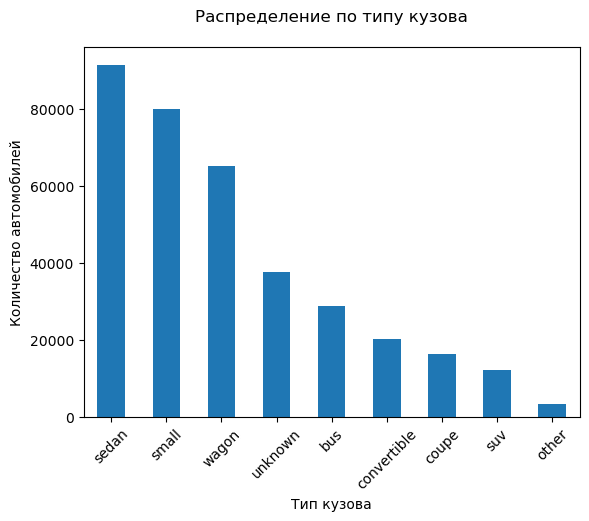

In [21]:
fig, ax = describe_categorical(data, 'VehicleType')
ax.set_title('Распределение по типу кузова\n')
ax.set_xlabel('Тип кузова')
ax.set_ylabel('Количество автомобилей')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

Представлены автомобили 7 типов + тип "other" + автомобили неизвестных типов (наша заглушка unknown). Больше всего в выборке автомобилей типа sedan и small, меньше всего - suv и other.


Признак категориальный, для обучения LinearRegression и DecisionTreeRegressor будем кодировать, используя one-hot encoding.

#### RegistrationYear

```RegistrationYear``` — год регистрации автомобиля.

RegistrationYear
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: count, Length: 151, dtype: int64


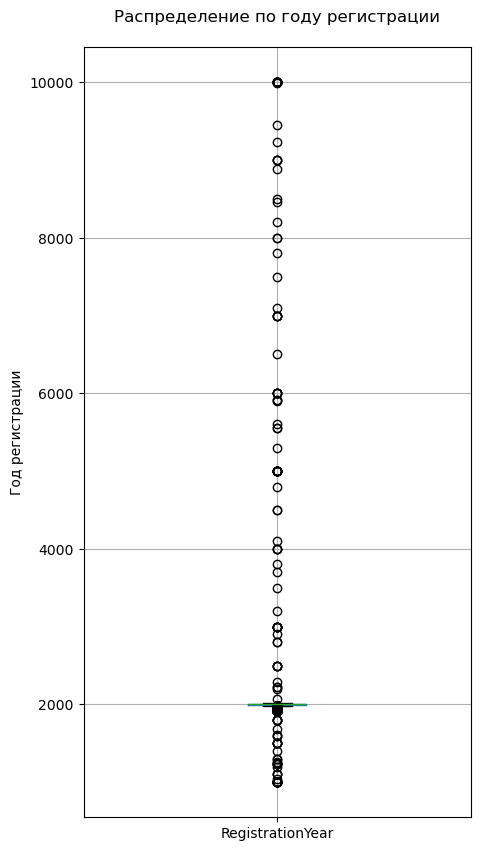

In [22]:
fig, ax = describe_numeric(data, 'RegistrationYear', discrete=True)
ax.set_title('Распределение по году регистрации\n')
ax.set_ylabel('Год регистрации')
plt.show()

Видим выбросы как сверху, так и снизу. В столбце хранится год регистрации автомобиля, удалим записи с аномально большим или аномально маленьким годом.

In [23]:
data['DateCreated'].max()

Timestamp('2016-04-07 00:00:00')

Самая свежая анкета в таблице создана в апреле 2016 года. Соответственно, в таблице не может быть автомобилей, зарегистрированных после 2016 года. Снизу ограничим 1950 годом, на случай наличия ретро-автомобилей среди объявлений.

In [24]:
data = data.query('RegistrationYear >= 1950 & RegistrationYear <= 2016')

RegistrationYear
1950      18
1951      12
1952       9
1953      14
1954      11
        ... 
2012    7178
2013    4131
2014    2537
2015    1302
2016    9599
Name: count, Length: 67, dtype: int64


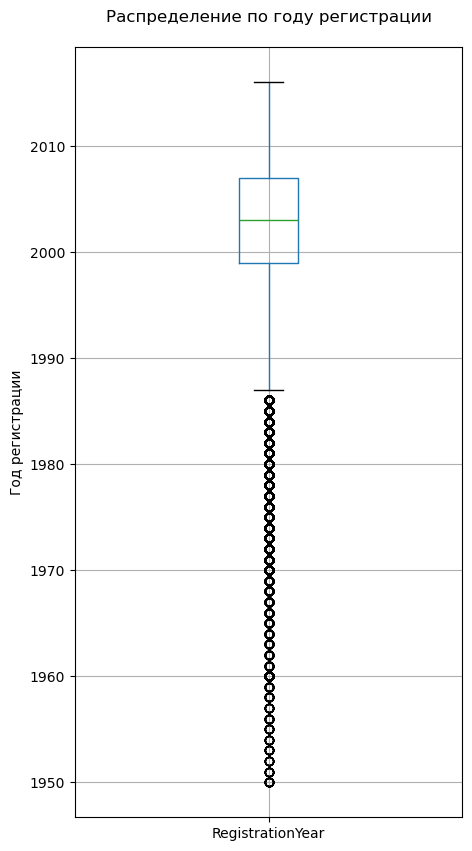

In [25]:
fig, ax = describe_numeric(data, 'RegistrationYear', discrete=True)
ax.set_title('Распределение по году регистрации\n')
ax.set_ylabel('Год регистрации')
plt.show()

Избавились от аномальных значений.

Признак количественный, для обучения линейной регрессии его нужно будет масштабировать.

#### Gearbox

```Gearbox``` — тип коробки передач.

Gearbox
manual     257481
auto        64296
unknown     17812
Name: count, dtype: int64


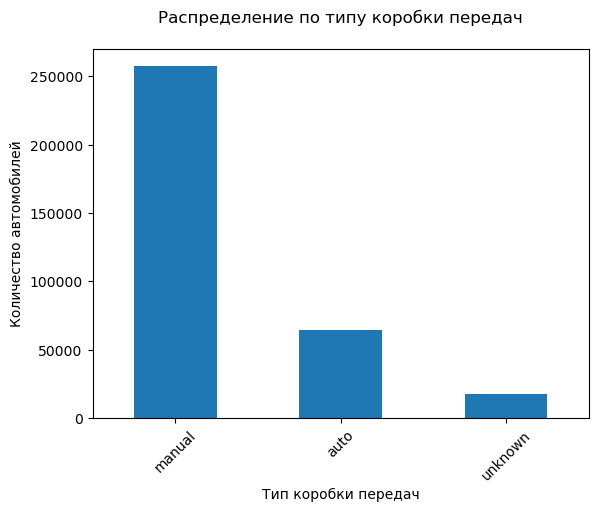

In [26]:
fig, ax = describe_categorical(data, 'Gearbox')
ax.set_title('Распределение по типу коробки передач\n')
ax.set_xlabel('Тип коробки передач')
ax.set_ylabel('Количество автомобилей')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

2 типа коробки передач - ручная и автомат, плюс заглушка. Преобладают машины с ручной коробкой передач.

Признак категориальный, для обучения LinearRegression и DecisionTreeRegressor будем кодировать, используя one-hot encoding.

#### Power

```Power``` — мощность (л. с.).

Power:
count    339589.000000
mean        111.045163
std         186.900896
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


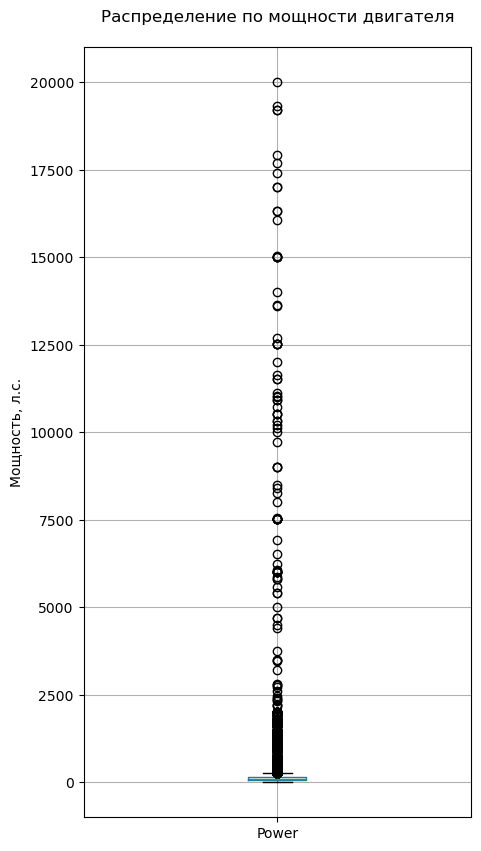

In [27]:
fig, ax = describe_numeric(data, 'Power')
ax.set_title('Распределение по мощности двигателя\n')
ax.set_ylabel('Мощность, л.с.')
plt.show()

Наблюдаются аномально высокие значения, а также нулевые значения. Будем считать аномальными значения более 1000 л.с. Удалим аномальные значения.

In [28]:
data = data.query('Power > 0 & Power < 1000')

Power:
count    302983.00000
mean        120.64330
std          54.85195
min           1.00000
25%          75.00000
50%         110.00000
75%         150.00000
max         999.00000
Name: Power, dtype: float64


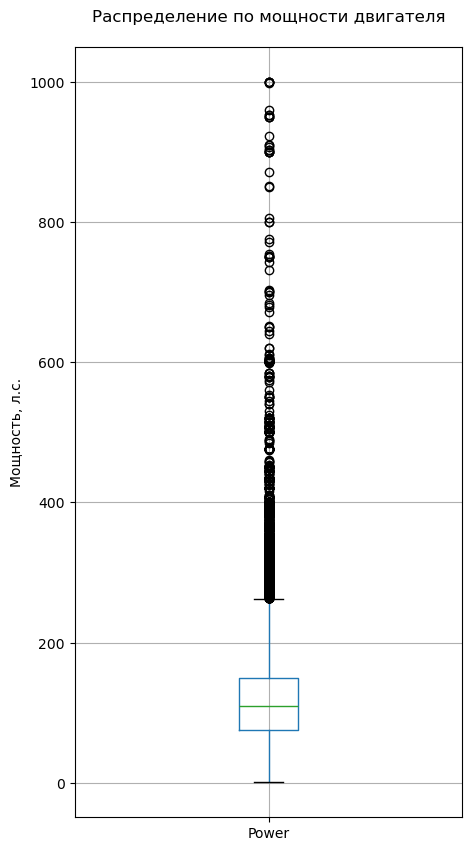

In [29]:
fig, ax = describe_numeric(data, 'Power')
ax.set_title('Распределение по мощности двигателя\n')
ax.set_ylabel('Мощность, л.с.')
plt.show()

#### Model

```Model``` — модель автомобиля.

In [30]:
sorted(data['Model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [31]:
data['Model'].nunique()

250

В таблице есть 250 уникальных моделей автомобиля. Признак категориальный, для линейной регрессии и дерева решений его нужно кодировать.

#### Kilometer

```Kilometer``` — пробег (км).

Kilometer
5000        3199
10000        952
20000       3351
30000       3975
40000       4555
50000       5712
60000       6883
70000       7886
80000       9143
90000      10441
100000     13035
125000     32272
150000    201579
Name: count, dtype: int64


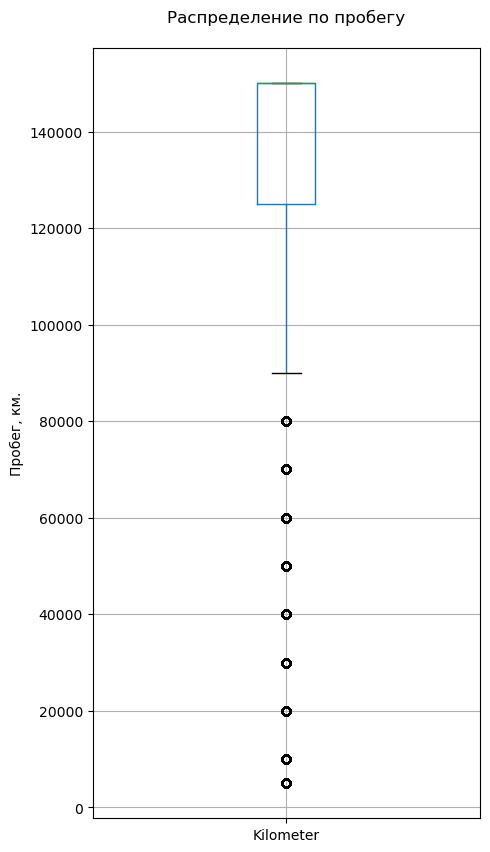

In [32]:
fig, ax = describe_numeric(data, 'Kilometer', discrete=True)
ax.set_title('Распределение по пробегу\n')
ax.set_ylabel('Пробег, км.')
plt.show()

Признак принимает ограниченное количество значений - вероятно, технические особенности сервиса, т.к. для покупки не важен пробег с точностью до километра. Нулевых значений нет - логично, т.к. у нас сервис по продаже автомобилей с пробегом.

Количественный признак, для обучения линейной регрессии будем масштабировать.

#### RegistrationMonth

```RegistrationMonth``` — месяц регистрации автомобиля.

In [33]:
data['RegistrationMonth'].value_counts().sort_index()

RegistrationMonth
0     19772
1     20576
2     19201
3     30866
4     26201
5     26119
6     28125
7     24282
8     20134
9     21323
10    23357
11    21397
12    21630
Name: count, dtype: int64

Кроме 12 значений от 1 до 12, соответствующих месяцам, присутствует также 0. Вероятно, так обозначен пропуск значения, если владелец анкеты его не заполнил.

Месяц регистрации автомобиля для нашей задачи не важен.

#### FuelType

```FuelType``` — тип топлива.

FuelType
petrol      191620
gasoline     88939
unknown      16761
lpg           4798
cng            488
hybrid         202
other           98
electric        77
Name: count, dtype: int64


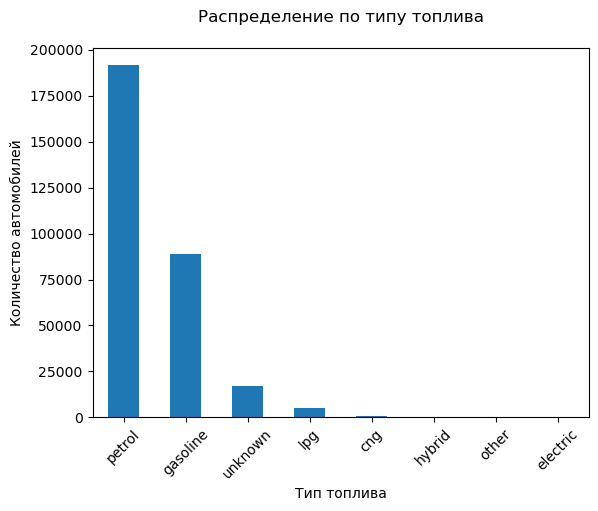

In [34]:
fig, ax = describe_categorical(data, 'FuelType')
ax.set_title('Распределение по типу топлива\n')
ax.set_xlabel('Тип топлива')
ax.set_ylabel('Количество автомобилей')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

Большинство машин имеют тип топлива petrol, на втором месте gasoline. Остальные типы представлены в небольшом количестве анкет.

Признак категориальный, для линейной регрессии и дерева решений его нужно кодировать.


#### Brand

```Brand``` — марка автомобиля.

In [35]:
sorted(data['Brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

In [36]:
data['Brand'].nunique()

40

В таблице 40 уникальных брендов автомобилей. Аномалий и неявных дубликатов не обнаружено.

Признак категориальный, для линейной регрессии и дерева решений его нужно кодировать.

#### Repaired

```Repaired``` — была машина в ремонте или нет.

Repaired
no         227300
unknown     45302
yes         30381
Name: count, dtype: int64


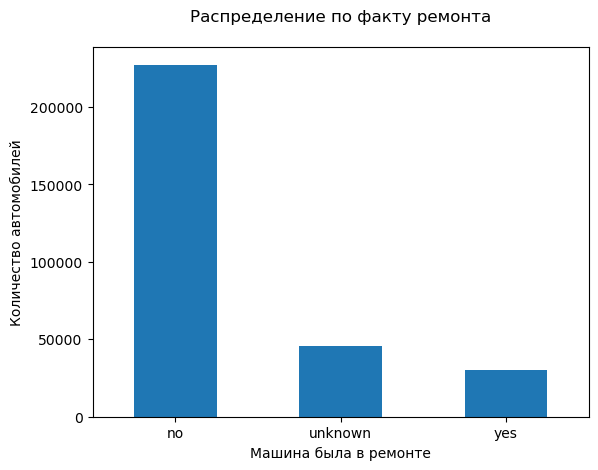

In [37]:
fig, ax = describe_categorical(data, 'Repaired')
ax.set_title('Распределение по факту ремонта\n')
ax.set_xlabel('Машина была в ремонте')
ax.set_ylabel('Количество автомобилей')
ax.tick_params(axis='x', labelrotation=0)
plt.show()

Большинство автомобилей в таблице не были в ремонте.

Признак категориальный, для линейной регрессии и дерева решений его нужно кодировать.

#### DateCreated

```DateCreated``` — дата создания анкеты.

In [38]:
data['DateCreated'].describe()

count                           302983
mean     2016-03-20 19:21:30.500127488
min                2015-03-20 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [39]:
'Анкет, созданных до марта 2016 года: {:.2%}'.format(data.query('DateCreated < "2016-03-01"').shape[0] / data.shape[0])

'Анкет, созданных до марта 2016 года: 0.15%'

В таблице есть объявления, созданные с марта 2015 года по апрель 2016. Дата создания анкеты могла бы быть полезна для определения цены, например, чтобы учитывать инфляцию или сезонные изменения спроса. Но большая часть анкет (99%) созданы в марте-апреле 2016 года, поэтому использовать в обучении этот признак смысла не имеет.

#### NumberOfPictures

```NumberOfPictures``` — количество фотографий автомобиля.

In [40]:
data['NumberOfPictures'].value_counts()

NumberOfPictures
0    302983
Name: count, dtype: int64

Для всех анкет этот признак принимает значение 0. Но даже если бы значений было несколько, количество фотографий в анкете вряд ли влияет на цену автомобиля.

#### PostalCode

```PostalCode``` — почтовый индекс владельца анкеты (пользователя).

In [41]:
data['PostalCode'].value_counts()

PostalCode
10115    801
65428    513
66333    287
60311    263
52525    257
        ... 
21360      1
26906      1
25868      1
6638       1
95691      1
Name: count, Length: 8119, dtype: int64

Почтовый индекс владельца анкеты не влияет на стоимость автомобиля.

####  LastSeen

```LastSeen``` — дата последней активности пользователя.

In [42]:
data['LastSeen'].describe()

count                           302983
mean     2016-03-30 04:24:38.371987712
min                2016-03-05 14:15:08
25%                2016-03-23 12:48:18
50%                2016-04-04 00:41:17
75%                2016-04-06 10:45:46
max                2016-04-07 14:58:51
Name: LastSeen, dtype: object

Аномальных значений не наблюдается. В любом случае, время последней активности пользователя не влияет на стоимость автомобиля.


#### Price

```Price``` — цена (евро). Целевой признак.

Price:
count    302983.000000
mean       4751.321427
std        4615.597497
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64


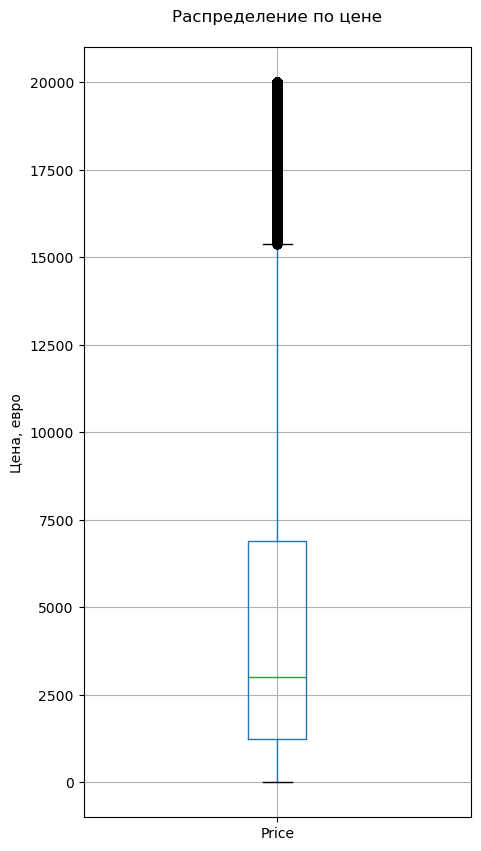

In [43]:
fig, ax = describe_numeric(data, 'Price')
ax.set_title('Распределение по цене\n')
ax.set_ylabel('Цена, евро')
plt.show()

Есть нулевые значения цены, которые можно считать аномальными. Удалим их.

In [44]:
data = data.query('Price > 0')

In [45]:
data = data.reset_index(drop=True)

In [46]:
data.shape

(296583, 16)

Проверим данные на дубликаты по релевантным столбцам.

In [47]:
relevant_cols = ['VehicleType', 'RegistrationYear', 'Gearbox', \
                 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'Price']

In [48]:
data.duplicated(subset=relevant_cols).sum()

39089

In [49]:
data.shape

(296583, 16)

Если рассматривать подмножество релевантных столбцов, то видим еще дубликаты. Удалим их.


In [50]:
data = data.drop_duplicates(subset=relevant_cols).reset_index(drop=True)

In [51]:
data.duplicated(subset=relevant_cols).sum()

0

In [52]:
data.shape

(257494, 16)

#### Исследовательский анализ - итог

Провели исследовательский анализ данных.
В таблице ```data``` (```autos.csv```) данные о 296583 автомобилях (после удаления дубликатов и аномальных значений).

1. ```DateCrawled``` — в таблице есть данные об объявлениях, скачанных в период с 2016-03-05 по 2016-04-07. Для обучения этот столбец не представляет особой ценности.
2. ```VehicleType``` — представлены автомобили 7 типов + тип "other" + автомобили неизвестных типов (наша заглушка unknown). Больше всего в выборке автомобилей типа sedan и small, меньше всего - suv и other.
3. ```RegistrationYear``` — в таблице обнаружены аномальные значения. Удалили записи с годом регистрации менее 1950 и более 2016 (2016 - год создания самой свежей анкеты, поэтому в таблице не может быть автомобиля с регистрацией позже 2016).
4. ```Gearbox``` — 2 типа коробки передач - ручная и автомат, плюс заглушка. Преобладают машины с ручной коробкой передач.
5. ```Power``` — наблюдаются аномально высокие значения, а также нулевые значения. Удалили аномальные значения более 1000 л.с. и нулевые значения.
6. ```Model``` — в таблице представлено 248 уникальных моделей автомобилей, а также  other и unknown.
7. ```Kilometer``` — дискретный, принимает значения от 5000 до 150000 километров. Аномалий не обнаружено.
8. ```RegistrationMonth``` — месяц регистрации автомобиля, для нас ценности не представляет.
9. ```FuelType``` — большинство машин имеют тип топлива petrol, на втором месте gasoline. Остальные типы представлены в небольшом количестве анкет.
10. ```Brand``` — в таблице 40 уникальных брендов автомобилей. Аномалий и неявных дубликатов не обнаружено
11. ```Repaired``` — большинство автомобилей в таблице не были в ремонте.
12. ```DateCreated``` — в таблице есть объявления, созданные с марта 2015 года по апрель 2016. Дата создания анкеты могла бы быть полезна для определения цены, например, чтобы учитывать инфляцию или сезонные изменения спроса. Но большая часть анкет (99%) созданы в марте-апреле 2016 года, поэтому использовать в обучении этот признак смысла не имеет.
13. ```NumberOfPictures``` — для всех анкет этот признак принимает значение 0. Но даже если бы значений было несколько, количество фотографий в анкете вряд ли влияет на цену автомобиля.
14. ```PostalCode``` — почтовый индекс владельца анкеты не влияет на стоимость автомобиля.
15. ```LastSeen``` — аномальных значений не наблюдается. В любом случае, время последней активности пользователя не влияет на стоимость автомобиля.
16. ```Price``` - обнаружены нулевые значения цены, которые можно считать аномальными. Удалили эти значения.

Для обучения предлагается использовать следующие входные признаки:
+ ```VehicleType```
+ ```RegistrationYear```
+ ```Gearbox```
+ ```Power```
+ ```Model```
+ ```Kilometer```
+ ```FuelType```
+ ```Brand```
+ ```Repaired```

### Корреляционный анализ

Проведем корреляционный анализ данных, проверим признаки на наличие мультиколлинеарности.

In [53]:
interval_cols = ['Price', 'Power', 'RegistrationYear', 'Kilometer']

In [54]:
phik_overview = phik_matrix(data[relevant_cols], interval_cols=interval_cols)

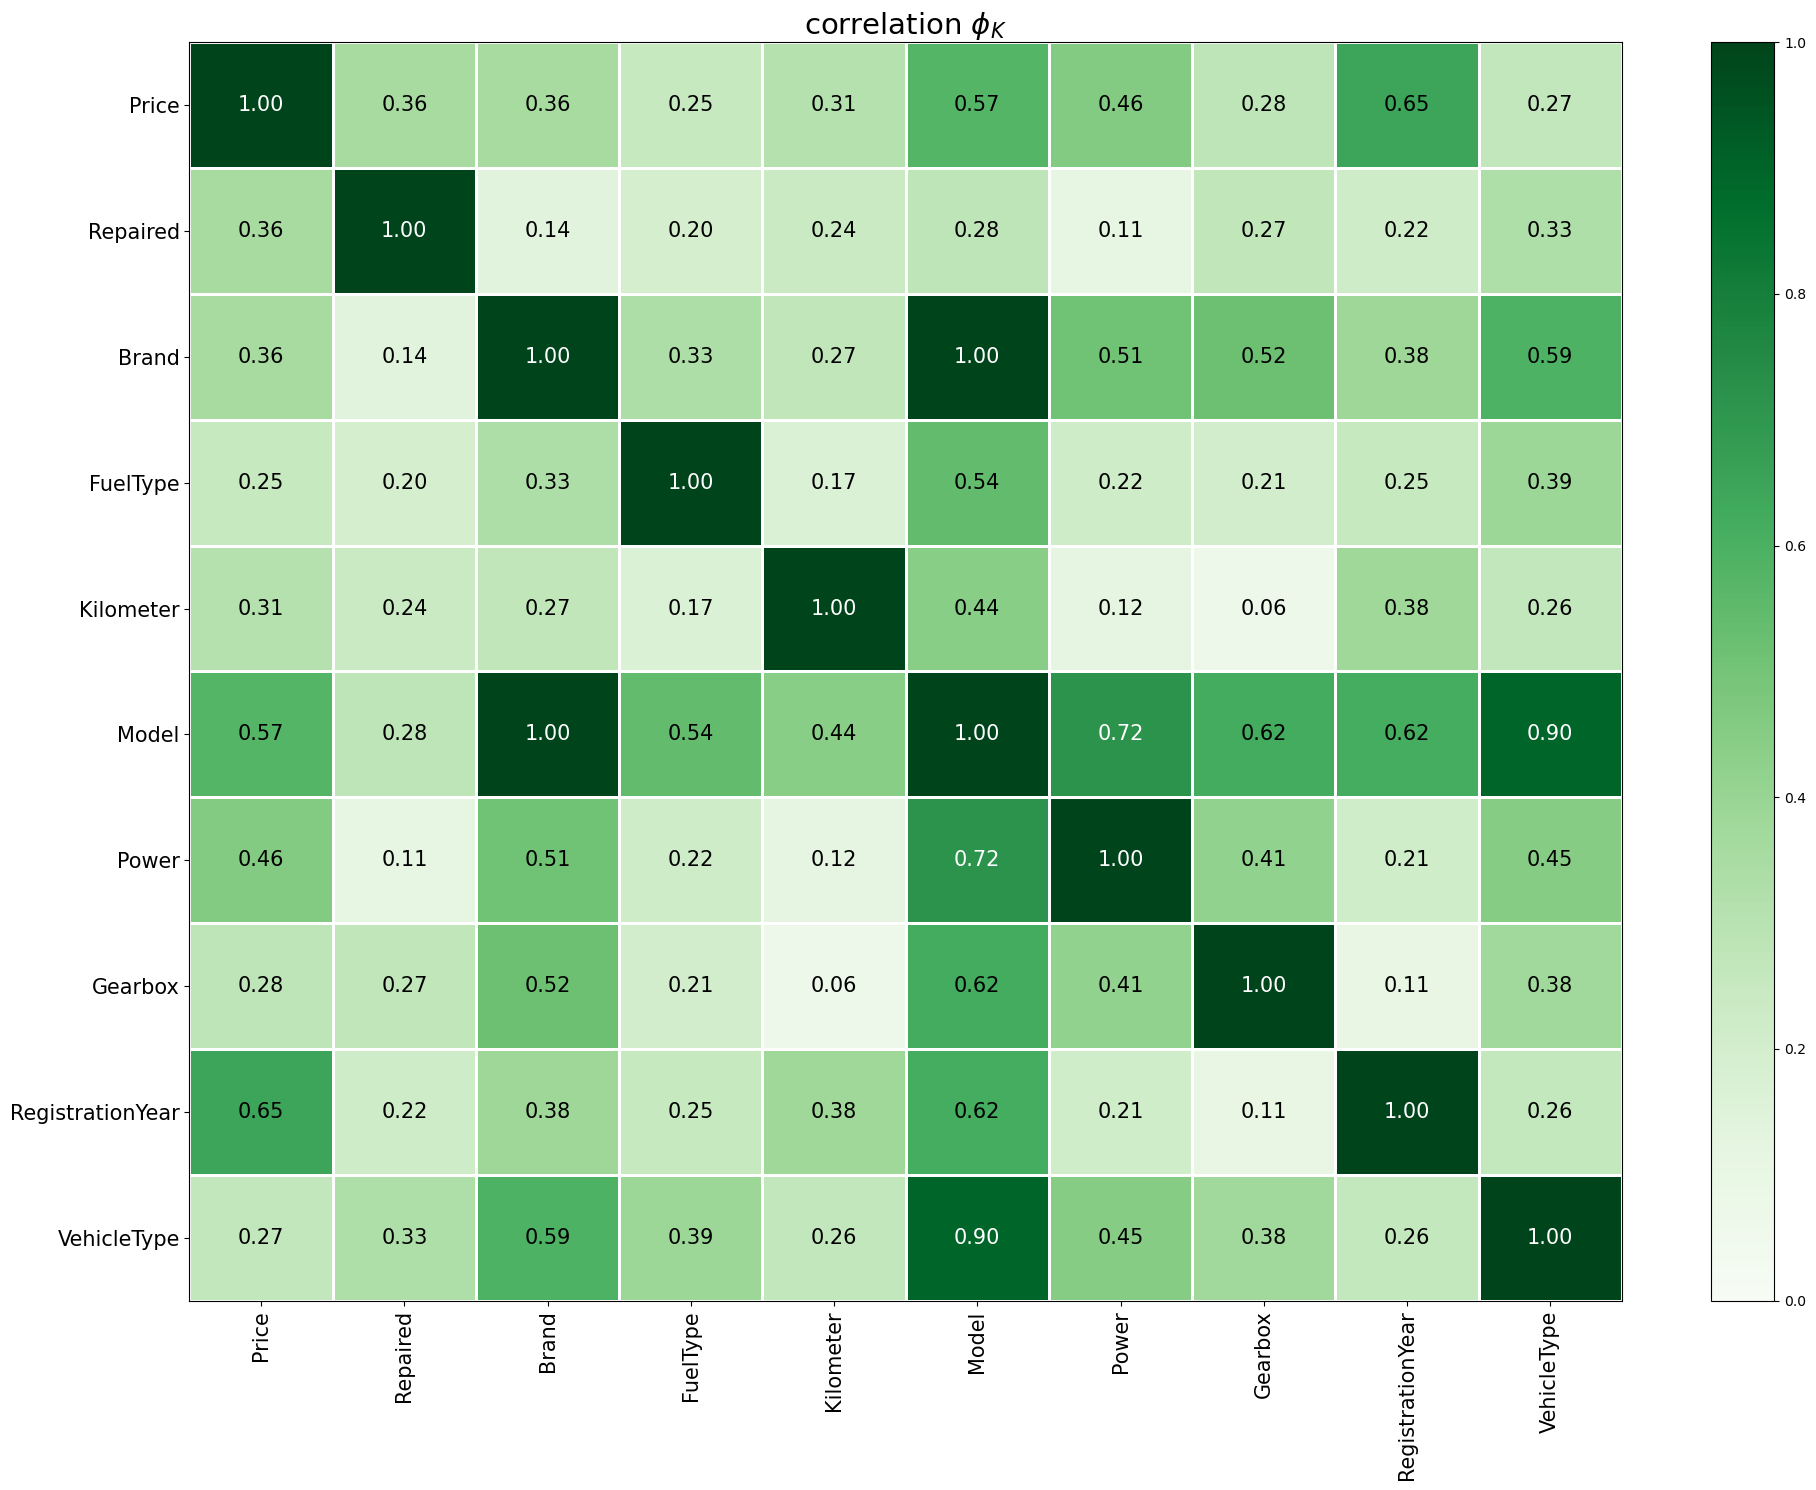

In [55]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Наблюдаем сильную связь признака Model с признаком Brand, т.к. в основном названия моделей уникальны для бренда.

In [56]:
data.groupby('Model')['Brand'].nunique().sort_values(ascending=False)

Model
unknown       40
other         39
grand          3
3_reihe        2
freelander     2
              ..
cx_reihe       1
delta          1
doblo          1
ducato         1
zafira         1
Name: Brand, Length: 250, dtype: int64

Удалять признак Brand не будем, т.к. в таблице есть неуникальные для брендов значения признака Model.

### Подготовка данных - итог

Провели подготовку данных для обучения моделей.

Провели предобработку данных.
1. Пропуски обнаружены в категориальных столбцах ```Repaired```, ```VehicleType```, ```FuelType```, ```Gearbox```, ```Model```. Заполнили пропуски заглушкой "unknown".
2. Привели даты к типу datetime.
3. Удалили явные дубликаты.

Провели исследовательский анализ данных.
В таблице ```data``` (```autos.csv```) данные о 296583 автомобилях (после удаления дубликатов и аномальных значений).
1. ```DateCrawled``` — в таблице есть данные об объявлениях, скачанных в период с 2016-03-05 по 2016-04-07. Для обучения этот столбец не представляет особой ценности.
2. ```VehicleType``` — представлены автомобили 7 типов + тип "other" + автомобили неизвестных типов (наша заглушка unknown). Больше всего в выборке автомобилей типа sedan и small, меньше всего - suv и other.
3. ```RegistrationYear``` — в таблице обнаружены аномальные значения. Удалили записи с годом регистрации менее 1950 и более 2016 (2016 - год создания самой свежей анкеты, поэтому в таблице не может быть автомобиля с регистрацией позже 2016).
4. ```Gearbox``` — 2 типа коробки передач - ручная и автомат, плюс заглушка. Преобладают машины с ручной коробкой передач.
5. ```Power``` — наблюдаются аномально высокие значения, а также нулевые значения. Удалили аномальные значения более 1000 л.с. и нулевые значения.
6. ```Model``` — в таблице представлено 248 уникальных моделей автомобилей, а также  other и unknown.
7. ```Kilometer``` — дискретный, принимает значения от 5000 до 150000 километров. Аномалий не обнаружено.
8. ```RegistrationMonth``` — месяц регистрации автомобиля, для нас ценности не представляет.
9. ```FuelType``` — большинство машин имеют тип топлива petrol, на втором месте gasoline. Остальные типы представлены в небольшом количестве анкет.
10. ```Brand``` — в таблице 40 уникальных брендов автомобилей. Аномалий и неявных дубликатов не обнаружено
11. ```Repaired``` — большинство автомобилей в таблице не были в ремонте.
12. ```DateCreated``` — в таблице есть объявления, созданные с марта 2015 года по апрель 2016. Дата создания анкеты могла бы быть полезна для определения цены, например, чтобы учитывать инфляцию или сезонные изменения спроса. Но большая часть анкет (99%) созданы в марте-апреле 2016 года, поэтому использовать в обучении этот признак смысла не имеет.
13. ```NumberOfPictures``` — для всех анкет этот признак принимает значение 0. Но даже если бы значений было несколько, количество фотографий в анкете вряд ли влияет на цену автомобиля.
14. ```PostalCode``` — почтовый индекс владельца анкеты не влияет на стоимость автомобиля.
15. ```LastSeen``` — аномальных значений не наблюдается. В любом случае, время последней активности пользователя не влияет на стоимость автомобиля.
16. ```Price``` - обнаружены нулевые значения цены, которые можно считать аномальными. Удалили эти значения.

Провели корреляционный анализ данных.
Наблюдаем сильную связь признака Model с признаком Brand, т.к. многие наименования моделей уникальны для брендов.

Для обучения предлагается использовать следующие входные признаки: 
+ ```VehicleType```
+ ```RegistrationYear```
+ ```Gearbox```
+ ```Power```
+ ```Kilometer```
+ ```FuelType```
+ ```Brand```
+ ```Model```
+ ```Repaired```

Проверили данные на дубликаты по подмножеству релевантных столбцов, удалили дубликаты.

## Обучение моделей

### Подготовка выборки

Подготовим выборки для обучения моделей.

В качестве входных признаков будем использовать следующие признаки:
+ VehicleType
+ RegistrationYear
+ Gearbox
+ Power
+ Kilometer
+ FuelType
+ Brand
+ Repaired

Целевой признак - Price.

In [57]:
features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 'Brand', 'Repaired', 'Model']

In [58]:
X = data[features]

In [59]:
y = data['Price']

Проверим размерности.

In [60]:
data.shape, X.shape, y.shape

((257494, 16), (257494, 9), (257494,))

Разделим выборку на train (60%), valid (20%) и test (20%).

In [61]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

In [62]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=RANDOM_STATE)

Проверим размерности.

In [63]:
data.shape

(257494, 16)

In [64]:
X_train.shape, X_test.shape, X_valid.shape

((154496, 9), (51499, 9), (51499, 9))

In [65]:
X_train.shape[0] + X_test.shape[0] + X_valid.shape[0]

257494

In [66]:
y_train.shape, y_test.shape, y_valid.shape

((154496,), (51499,), (51499,))

С размерностями всё ОК.

### Создание пайплайнов

Создадим список признаков, к которым надо применить масштабирование или кодирование.

In [67]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'Model']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

Добавляем в пайплайн OHE-кодирование для линейной регрессии.

In [68]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True)
        )
    ]
) 

Добавим в пайплайн Ordinal-кодирование для деревьев.

In [69]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                handle_unknown='use_encoded_value', 
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Объединяем шаги подготовки в пайплайн для линейной регрессии.

+ Применяем пайплайн ohe_pipe к данным ohe_columns, которые требуют OHE-кодирования. Это шаг ohe.
+ Масштабируем данные num_columns. Это шаг num.

In [70]:
data_preprocessor_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Для дерева решений не требуется проводить масштабирование.

In [71]:
data_preprocessor_tree = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns)
    ], 
    remainder='passthrough'
) 

### Подбор лучших параметров для LightGBM

LightBGM для работы с категориальными признаками требуется либо One-hot encoding, либо перевод признаков в pandas тип category. Т.к. у нас уже есть пайплайн для OHE, будем использовать его.

In [72]:
pipe_final_lgbm = Pipeline(
    [
        ('preprocessor', data_preprocessor_tree),
        ('models', LGBMRegressor())
    ]
)

In [73]:
param_grid_lgbm = [
    {
        'models': [LGBMRegressor(verbosity=-1)],
        'models__n_estimators': [100, 200],
        'models__learning_rate': [0.01, 0.05, 0.1]
    }
]

In [74]:
grid_search_lgbm = GridSearchCV(
    pipe_final_lgbm, 
    param_grid_lgbm, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [75]:
grid_search_lgbm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Repaired',
                                                                          'Model'])])),
                                       ('models', LGBMRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor(n_estimators=200,
                                                   verbosity=-1)],
                          'models__learning_rate': [0.01, 0.05, 0.1],
                          'models__n_estimators': [100, 200]}],
             scoring='neg_root_mean_squared_error')

Топ-5 моделей:

In [76]:
pd.set_option('display.max_colwidth', None)
(pd.DataFrame(grid_search_lgbm.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'param_models', 'mean_test_score','params']]
 .head()
)

,rank_test_score,param_models,mean_test_score,params
5,1,"LGBMRegressor(n_estimators=200, verbosity=-1)",-1657.744041,"{'models': LGBMRegressor(n_estimators=200, verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 200}"
3,2,"LGBMRegressor(n_estimators=200, verbosity=-1)",-1695.627162,"{'models': LGBMRegressor(n_estimators=200, verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 200}"
4,3,"LGBMRegressor(n_estimators=200, verbosity=-1)",-1699.083134,"{'models': LGBMRegressor(n_estimators=200, verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 100}"
2,4,"LGBMRegressor(n_estimators=200, verbosity=-1)",-1775.873227,"{'models': LGBMRegressor(n_estimators=200, verbosity=-1), 'models__learning_rate': 0.05, 'models__n_estimators': 100}"
1,5,"LGBMRegressor(n_estimators=200, verbosity=-1)",-2121.530293,"{'models': LGBMRegressor(n_estimators=200, verbosity=-1), 'models__learning_rate': 0.01, 'models__n_estimators': 200}"


In [77]:
print('Параметры лучшей модели:\n', grid_search_lgbm.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', grid_search_lgbm.best_score_*(-1))

Параметры лучшей модели:
 {'models': LGBMRegressor(n_estimators=200, verbosity=-1), 'models__learning_rate': 0.1, 'models__n_estimators': 200}

Метрика лучшей модели на кросс-валидации: 1657.7440406273188


### Подбор лучших параметров для CatBoost

Для CatBoost не требуется подготовка данных - ни масштабирование, ни какое-либо кодирование категориальных признаков.

In [78]:
pipe_final_cb = Pipeline([
    ('models', CatBoostRegressor())
])

In [79]:
param_grid_cb = [
    {
        'models': [CatBoostRegressor(logging_level='Silent')],
        'models__iterations': [50, 100, 200],
    }
]

In [80]:
grid_search_cb = GridSearchCV(
    pipe_final_cb, 
    param_grid_cb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [81]:
grid_search_cb.fit(X_train, y_train, models__cat_features=ohe_columns)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('models',
                                        <catboost.core.CatBoostRegressor object at 0x000002D6B5BB3B10>)]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>],
                          'models__iterations': [50, 100, 200]}],
             scoring='neg_root_mean_squared_error')

Рейтинг моделей:

In [82]:
pd.set_option('display.max_colwidth', None)
(pd.DataFrame(grid_search_cb.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'param_models', 'mean_test_score','params']]
 .head()
)

,rank_test_score,param_models,mean_test_score,params
2,1,<catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>,-1662.300695,"{'models': <catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>, 'models__iterations': 200}"
1,2,<catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>,-1687.629312,"{'models': <catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>, 'models__iterations': 100}"
0,3,<catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>,-1729.005434,"{'models': <catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>, 'models__iterations': 50}"


In [83]:
print('Параметры лучшей модели:\n', grid_search_cb.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', grid_search_cb.best_score_*(-1))

Параметры лучшей модели:
 {'models': <catboost.core.CatBoostRegressor object at 0x000002D6B5BCBED0>, 'models__iterations': 200}

Метрика лучшей модели на кросс-валидации: 1662.3006954518046


### Подбор лучших параметров для LinearRegression

Особых параметров для перебора у линейной регрессии тоже нет, поэтому обучим модель в следующем разделе, где также проанализируем время обучения и предсказания.

### Подбор лучших параметров для DecisionTreeRegressor

In [84]:
pipe_final_dt = Pipeline(
    [
        ('preprocessor', data_preprocessor_tree),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [85]:
param_grid_dt = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 10),
        'models__max_depth': [None] + list(range(1, 5)) 
    }
]

In [86]:
randomized_search_dt = RandomizedSearchCV(
    pipe_final_dt, 
    param_grid_dt, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [87]:
randomized_search_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Repaired',
                                                                                'Model'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(min_samples_split=8,
                                                                          random_state=42)],
                                         'models__max_depth': [None, 1, 2, 3,
                                                               4],
                                         'models__min_samples_split': range(2, 10)}],
                   random_state=42, scoring='neg_root_mean_squared_error')

Топ-5 моделей:

In [88]:
pd.set_option('display.max_colwidth', None)
(pd.DataFrame(randomized_search_dt.cv_results_)
 .sort_values(by='mean_test_score', ascending=False)
 [['rank_test_score', 'param_models', 'mean_test_score','params']]
 .head()
)

,rank_test_score,param_models,mean_test_score,params
9,1,"DecisionTreeRegressor(min_samples_split=8, random_state=42)",-1949.368155,"{'models__min_samples_split': 8, 'models__max_depth': None, 'models': DecisionTreeRegressor(min_samples_split=8, random_state=42)}"
4,2,"DecisionTreeRegressor(min_samples_split=8, random_state=42)",-1979.742306,"{'models__min_samples_split': 6, 'models__max_depth': None, 'models': DecisionTreeRegressor(min_samples_split=8, random_state=42)}"
6,3,"DecisionTreeRegressor(min_samples_split=8, random_state=42)",-2651.085877,"{'models__min_samples_split': 7, 'models__max_depth': 4, 'models': DecisionTreeRegressor(min_samples_split=8, random_state=42)}"
8,3,"DecisionTreeRegressor(min_samples_split=8, random_state=42)",-2651.085877,"{'models__min_samples_split': 9, 'models__max_depth': 4, 'models': DecisionTreeRegressor(min_samples_split=8, random_state=42)}"
3,5,"DecisionTreeRegressor(min_samples_split=8, random_state=42)",-2987.190063,"{'models__min_samples_split': 4, 'models__max_depth': 3, 'models': DecisionTreeRegressor(min_samples_split=8, random_state=42)}"


In [89]:
print('Параметры лучшей модели:\n', randomized_search_dt.best_params_)
print ('\nМетрика лучшей модели на кросс-валидации:', randomized_search_dt.best_score_*(-1))

Параметры лучшей модели:
 {'models__min_samples_split': 8, 'models__max_depth': None, 'models': DecisionTreeRegressor(min_samples_split=8, random_state=42)}

Метрика лучшей модели на кросс-валидации: 1949.3681548135187


### Обучение моделей - итог

Подготовили выборки для обучения моделей. Разделили данные на train/valid/test в соотношении 3:1:1.
Целевой признак - ```Price```, входные признаки - ```VehicleType```, ```RegistrationYear```, ```Gearbox```, ```Power```, ```Kilometer```, ```FuelType```, ```Brand```, ```Model```, ```Repaired```.

Собрали пайплайны для подготовки данных. Для линейной регрессии добавили масштабирование количественных признаков ```RegistrationYear```, ```Power```, ```Kilometer``` и one-hot кодирование категориальных, для деревьев - ordinal кодирование категориальных признаков ```VehicleType```, ```Gearbox```, ```FuelType```, ```Brand```, ```Repaired```. 

Используя GridSearch и RandomizedSearch подобрали лучшие параметры для моделей:
1. LGBMRegressor: ```learning_rate```: 0.1, ```n_estimators```: 200. RMSE лучшей модели на кросс-валидации: 1657.74.
2. CatBoost: ```iterations```: 200. RMSE лучшей модели на кросс-валидации: 1662.30.
3. DecisionTreeRegressor: ```min_samples_split```: 8, ```max_depth```: None. RMSE лучшей модели на кросс-валидации: 1949.37.

Также в сравнении будет участвовать LinearRegression, но для нее подбирать параметры не будем.

## Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей с подобранными нами лучшими параметрами.

### LightGBM

Параметры - learning_rate=0.1, n_estimators=200.

Обучим модель и посчитаем время.

In [90]:
lgbm_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_tree),
        ('models', LGBMRegressor(learning_rate=0.1, n_estimators=200, verbosity=-1))
    ]
)

In [94]:
%%timeit -o
lgbm_final.fit(X_train, y_train)

1.05 s ± 84.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.05 s ± 84.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [95]:
lgbm_train_time = _.average

Посчитаем время предсказания.

In [96]:
%%timeit -o
lgbm_final.predict(X_valid)

282 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 282 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [97]:
lgbm_predict_time = _.average

In [99]:
lgbm_valid_pred = lgbm_final.predict(X_valid)
lgbm_valid_rmse = mean_squared_error(y_valid, lgbm_valid_pred, squared=False)
lgbm_valid_rmse

1655.012396975731

Сравним с работой на категориальных признаках без кодирования. Для этого переведем категориальные признаки в тип category.

In [100]:
lgbm_final_1 = Pipeline(
    [
        ('models', LGBMRegressor(learning_rate=0.1, n_estimators=200, verbosity=-1))
    ]
)

In [101]:
X_train[ohe_columns] = X_train[ohe_columns].astype('category')
X_valid[ohe_columns] = X_valid[ohe_columns].astype('category')

In [102]:
%%timeit -o
lgbm_final_1.fit(X_train, y_train)

723 ms ± 62.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 723 ms ± 62.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [103]:
lgbm_train_time_no_encoding = _.average

In [104]:
%%timeit -o
lgbm_final_1.predict(X_valid)

203 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 203 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [105]:
lgbm_predict_time_no_encoding = _.average

In [108]:
lgbm_valid_pred1 = lgbm_final_1.predict(X_valid)
lgbm_valid_rmse1 = mean_squared_error(y_valid, lgbm_valid_pred1, squared=False)
lgbm_valid_rmse1

1618.1076229973114

Немного улучшилось время обучения и RMSE.

In [109]:
X_train[ohe_columns] = X_train[ohe_columns].astype('str')
X_valid[ohe_columns] = X_valid[ohe_columns].astype('str')

###  CatBoost

Параметры - iterations=200.

Обучим модель и посчитаем время.

In [110]:
cb_final = Pipeline(
    [
        ('models', CatBoostRegressor(iterations=200, logging_level='Silent'))
    ]
)

In [111]:
%%timeit -o
cb_final.fit(X_train, y_train, models__cat_features=ohe_columns)

14.6 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 14.6 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [112]:
cb_train_time = _.average

Посчитаем время предсказания.

In [114]:
%%timeit -o
cb_final.predict(X_valid)

130 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 130 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [115]:
cb_predict_time = _.average

In [117]:
cb_valid_pred = cb_final.predict(X_valid)
cb_valid_rmse = mean_squared_error(y_valid, cb_valid_pred, squared=False)
cb_valid_rmse

1658.5841337716354

###  LinearRegression

Для линейной регрессии требуется и масштабирование количественных признаков, и кодирование категориальных. 

In [118]:
lr_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_lr),
        ('models', LinearRegression())
    ]
)

In [119]:
%%timeit -o
lr_final.fit(X_train, y_train)

2.68 s ± 75.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2.68 s ± 75.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [120]:
lr_train_time = _.average

Посчитаем время предсказания.

In [121]:
%%timeit -o
lr_final.predict(X_valid)

118 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 118 ms ± 658 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [122]:
lr_predict_time = _.average

In [123]:
lr_valid_pred = lr_final.predict(X_valid)
lr_valid_rmse = mean_squared_error(y_valid, lr_valid_pred, squared=False)
lr_valid_rmse

2655.9720050403407

### DecisionTreeRegressor

Параметры - min_samples_split=8, max_depth=None

Обучим модель и посчитаем время.

In [124]:
dt_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_tree),
        ('models', DecisionTreeRegressor(min_samples_split=8, random_state=RANDOM_STATE))
    ]
)

In [126]:
%%timeit -o
dt_final.fit(X_train, y_train)

15.5 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 15.5 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [127]:
dt_train_time = _.average

Посчитаем время предсказания.

In [128]:
%%timeit -o
dt_final.predict(X_valid)

134 ms ± 808 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 134 ms ± 808 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [129]:
dt_predict_time = _.average

In [130]:
dt_valid_pred = dt_final.predict(X_valid)
dt_valid_rmse = mean_squared_error(y_valid, dt_valid_pred, squared=False)
dt_valid_rmse

1919.9432414730966

### Сравнение моделей

Сравним модели по полученным нами данным.

In [142]:
train_time_col = [lgbm_train_time, lgbm_train_time_no_encoding, cb_train_time, lr_train_time, dt_train_time]
predict_time_col = [lgbm_predict_time, lgbm_predict_time_no_encoding, cb_predict_time, lr_predict_time, dt_predict_time]
predict_time_col = [x * 1000 for x in predict_time_col]
rmse_col = [lgbm_valid_rmse, lgbm_valid_rmse1, cb_valid_rmse, lr_valid_rmse, dt_valid_rmse]
rmse_col = [round(x) for x in rmse_col]

In [143]:
results = {'Обучение, с': train_time_col, 'Предсказание, мс': predict_time_col, 'RMSE': rmse_col}
results_table = pd.DataFrame(results, index=['LightGBM', 'LightGBM без кодирования', 'CatBoost', 'LinearRegression', 'DecisionTree'])

In [153]:
(results_table
 .style
 .format({'Обучение, с': '{:.2f}', 'Предсказание, мс': '{:.0f}'})
 .highlight_min(subset=['Обучение, с', 'Предсказание, мс', 'RMSE'], color='lightgreen')
 .apply(lambda row: ['background: red'] if (row['RMSE'] > RMSE_THRESHOLD) else [''], axis=1, subset=['RMSE'])
)

,"Обучение, с","Предсказание, мс",RMSE
LightGBM,1.05,282,1655
LightGBM без кодирования,0.72,203,1618
CatBoost,14.56,130,1659
LinearRegression,2.68,118,2656
DecisionTree,15.54,134,1920


Исключаем из сравнения линейную регрессию, т.к. хотя время обучения и предсказания у нее небольшие, метрика RMSE у нее превышает допустимый порог 2500.

In [154]:
(results_table.drop('LinearRegression')
 .style
 .format({'Обучение, с': '{:.2f}', 'Предсказание, мс': '{:.0f}'})
 .highlight_min(subset=['Обучение, с', 'Предсказание, мс', 'RMSE'], color='lightgreen')
 .apply(lambda row: ['background: red'] if (row['RMSE'] > RMSE_THRESHOLD) else [''], axis=1, subset=['RMSE'])
)

,"Обучение, с","Предсказание, мс",RMSE
LightGBM,1.05,282,1655
LightGBM без кодирования,0.72,203,1618
CatBoost,14.56,130,1659
DecisionTree,15.54,134,1920


У модели LGBMRegressor - наименьшее время обучения (1 секунда при кодировании категориальных признаков OrdinalEncoder и 0.7 секунды, если она обрабатывает категориальные признаки сама) и лучшее RMSE. Время предсказания лучше у CatBoost и DecisionTree - 130 мс против в 2 раза большего у LightGBM.

RMSE бустингов сопоставимы, поэтому в целом можно выбирать любой из двух, в зависимости от того, важнее нам скорость обучения или скорость предсказания.

### Тестирование лучшей модели

Посмотрим на результат LightGBM на тестовой выборке.

In [149]:
lgbm_test_pred = lgbm_final.predict(X_test)
lgbm_test_rmse = mean_squared_error(y_test, lgbm_test_pred, squared=False)
lgbm_test_rmse

1658.449360067163

In [151]:
X_test[ohe_columns] = X_test[ohe_columns].astype('category')

In [152]:
lgbm_test_pred1 = lgbm_final_1.predict(X_test)
lgbm_test_rmse1 = mean_squared_error(y_test, lgbm_test_pred1, squared=False)
lgbm_test_rmse1

1613.8240637492815

Посмотрим на результат CatBoost на тестовой выборке.

In [150]:
cb_test_pred = cb_final.predict(X_test)
cb_test_rmse = mean_squared_error(y_test, cb_test_pred, squared=False)
cb_test_rmse

1662.1896169128333

Как и на валидационной выборке, RMSE моделей в целом сопоставимы и не превышают заданного порога. Лучший результат у LightGBM без использования внешнего ordinal encoder.

###  Анализ моделей - итог

Проанализировали время обучения, время предсказания и качество моделей на валидационной выборке.
Сравнивали 4 модели: LightGBM, Catboost, LinearRegression, DecisionTree.

<table>
    <tr>
        <th>Модель</th>
        <th>Обучение, с</th>
        <th>Предсказание, мс</th> 
        <th>RMSE</th> 
    </tr>
    <tr>
        <td>LightGBM</td>
        <td>1.05</td>
        <td>282</td>
        <td>1655</td>
    </tr>
    <tr>
        <td>LightGBM без кодирования</td>
        <td><font color='green'>0.72</font></td>
        <td>203</td>
        <td><font color='green'>1618</font></td>
    </tr>
    <tr>
        <td>CatBoost</td>
        <td>14.6</td>
        <td>130</td>
        <td>1659</td>
    </tr>
    <tr>
        <td>LinearRegression</td>
        <td>2.68</td>
        <td><font color='green'>118</font></td>
        <td><font color='red'>2656</font></td>
    </tr>
    <tr>
        <td>DecisionTree</td>
        <td>15.54</td>
        <td>134</td>
        <td>1920</td>
    </tr>
</table>

Исключили из сравнения линейную регрессию, т.к. хотя время обучения и предсказания у нее наименьшие, метрика RMSE у нее превышает заданный порог 2500.

<table>
    <tr>
        <th>Модель</th>
        <th>Обучение, с</th>
        <th>Предсказание, мс</th> 
        <th>RMSE</th> 
    </tr>
    <tr>
        <td>LightGBM</td>
        <td>1.05</td>
        <td>282</td>
        <td>1655</td>
    </tr>
    <tr>
        <td>LightGBM без кодирования</td>
        <td><font color='green'>0.72</font></td>
        <td>203</td>
        <td><font color='green'>1618</font></td>
    </tr>
    <tr>
        <td>CatBoost</td>
        <td>14.6</td>
        <td><font color='green'>130</font></td>
        <td>1659</td>
    </tr>
    <tr>
        <td>DecisionTree</td>
        <td>15.54</td>
        <td>134</td>
        <td>1920</td>
    </tr>
</table>

У модели LGBMRegressor - наименьшее время обучения (1 секунда при кодировании категориальных признаков OrdinalEncoder и 0.7 секунды, если она обрабатывает категориальные признаки сама) и лучшее RMSE. Время предсказания лучше у CatBoost и DecisionTree - 130 мс против в 2 раза большего у LightGBM.

RMSE бустингов сопоставимы, поэтому в целом можно выбирать любой из двух, в зависимости от того, важнее нам скорость обучения или скорость предсказания.


Проверили качество лучших моделей на тестовой выборке.

Результат LightGBM - 1658.4. Результат CatBoost - 1662.2, LightGBM без использования OrdinalEncoder в пайплайне - 1613.8. Как и на валидационной выборке, RMSE моделей в целом сопоставимы и не превышают заданного порога. Лучший результат у LightGBM без использования внешнего ordinal encoder.

## Общий вывод

Проанализировали данные о характеристиках и ценах автомобилей, обучили модели для предсказания стоимости автомобиля.

Провели подготовку данных для обучения моделей.

1. Провели предобработку данных.
    + Заполнили пропуски в категориальных столбцах ```Repaired```, ```VehicleType```, ```FuelType```, ```Gearbox```, ```Model``` заглушкой "unknown".
    + Привели даты к типу datetime.
    + Удалили явные дубликаты.

2. Провели исследовательский анализ данных.
    + Проверили данные на наличие аномалий. Удалили аномальные значения из столбцов ```RegistrationYear```, ```Power```, ```Price```.
    + Определили список релевантных входных признаков.
    + Для обучения выбрали следующие входные признаки: 
        + ```VehicleType```
        + ```RegistrationYear```
        + ```Gearbox```
        + ```Power```
        + ```Kilometer```
        + ```FuelType```
        + ```Brand```
        + ```Model```
        + ```Repaired```
3. Подготовили выборки для обучения моделей. Разделили данные на train/valid/test в соотношении 3:1:1.
    Собрали пайплайны для подготовки данных. Для линейной регрессии добавили масштабирование количественных признаков ```RegistrationYear```, ```Power```, ```Kilometer```, для деревьев - one-hot кодирование категориальных признаков ```VehicleType```, ```Gearbox```, ```FuelType```, ```Brand```, ```Repaired```, ```Model```. 

    Используя GridSearch и RandomizedSearch подобрали лучшие параметры для моделей:
    + LGBMRegressor: ```learning_rate```: 0.1, ```n_estimators```: 200. RMSE лучшей модели на кросс-валидации: 1669.60.
    + CatBoost: ```iterations```: 200. RMSE лучшей модели на кросс-валидации: 1672.32.
    + DecisionTreeRegressor: ```min_samples_split```: 8, ```max_depth```: None. RMSE лучшей модели на кросс-валидации: 1891.92.
4. Проанализировали время обучения, время предсказания и качество моделей на валидационной выборке.
    Сравнивали 4 модели: LightGBM, Catboost, LinearRegression, DecisionTree.
    <table>
        <tr>
            <th>Модель</th>
            <th>Обучение, с</th>
            <th>Предсказание, мс</th> 
            <th>RMSE</th> 
        </tr>
        <tr>
            <td>LightGBM</td>
            <td>1.05</td>
            <td>282</td>
            <td>1655</td>
        </tr>
        <tr>
            <td>LightGBM без кодирования</td>
            <td><font color='green'>0.72</font></td>
            <td>203</td>
            <td><font color='green'>1618</font></td>
        </tr>
        <tr>
            <td>CatBoost</td>
            <td>14.6</td>
            <td>130</td>
            <td>1659</td>
        </tr>
        <tr>
            <td>LinearRegression</td>
            <td>2.68</td>
            <td><font color='green'>118</font></td>
            <td><font color='red'>2656</font></td>
        </tr>
        <tr>
            <td>DecisionTree</td>
            <td>15.54</td>
            <td>134</td>
            <td>1920</td>
        </tr>
    </table>

    Исключили из сравнения линейную регрессию, т.к. хотя время обучения и предсказания у нее наименьшие, метрика RMSE у нее превышает заданный порог 2500.

    <table>
        <tr>
            <th>Модель</th>
            <th>Обучение, с</th>
            <th>Предсказание, мс</th> 
            <th>RMSE</th> 
        </tr>
        <tr>
            <td>LightGBM</td>
            <td>1.05</td>
            <td>282</td>
            <td>1655</td>
        </tr>
        <tr>
            <td>LightGBM без кодирования</td>
            <td><font color='green'>0.72</font></td>
            <td>203</td>
            <td><font color='green'>1618</font></td>
        </tr>
        <tr>
            <td>CatBoost</td>
            <td>14.6</td>
            <td><font color='green'>130</font></td>
            <td>1659</td>
        </tr>
        <tr>
            <td>DecisionTree</td>
            <td>15.54</td>
            <td>134</td>
            <td>1920</td>
        </tr>
    </table>

    У модели LGBMRegressor - наименьшее время обучения (1 секунда при кодировании категориальных признаков OrdinalEncoder и 0.7 секунды, если она обрабатывает категориальные признаки сама) и лучшее RMSE. Время предсказания лучше у CatBoost и DecisionTree - 130 мс против в 2 раза большего у LightGBM.

    RMSE бустингов сопоставимы, поэтому в целом можно выбирать любой из двух, в зависимости от того, важнее нам скорость обучения или скорость предсказания.

    Проверили качество лучших моделей на тестовой выборке.

    Результат LightGBM - 1658.4. Результат CatBoost - 1662.2, LightGBM без использования OrdinalEncoder в пайплайне - 1613.8. Как и на валидационной выборке, RMSE моделей в целом сопоставимы и удовлетворяют требованию RMSE ≤ 2500. Лучший результат у LightGBM без использования внешнего ordinal encoder.
    

[В начало](#title)